# Node representation learning with Deep Graph Infomax and HinSAGE


This demo demonstrates how to perform unsupervised training of a GCN, GAT, APPNP, or GraphSAGE model using the Deep Graph Infomax algorithm (https://arxiv.org/pdf/1809.10341.pdf) on the GM12878_sample dataset. 

As with all StellarGraph workflows: first we load the dataset, next we create our data generators, and then we train our model. We then take the embeddings created through unsupervised training and predict the node classes using logistic regression.

In [3]:
import networkx as nx
import numpy as np

from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    DirectedGraphSAGENodeGenerator,
    HinSAGENodeGenerator,
)
from stellargraph import StellarDiGraph
from stellargraph.layer import DeepGraphInfomax, DirectedGraphSAGE, MeanPoolingAggregator

from stellargraph import datasets
from stellargraph.utils import plot_history
from stellargraph.random import set_seed

import pandas as pd
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model
if tf.test.gpu_device_name():
  print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

from pathlib import Path
from helper import PreprocessForTrail, FeatureForTrail

set_seed(2)
tf.random.set_seed(2)

Default GPU Device:/device:GPU:0


## Load graph and node features

In [4]:
DATA_DIR = Path("../../data/")
FEATURE_DIR = Path("../../data/features/")
FEATURE_NAME = 'adjacentTFs_trail'
MODEL_NAME='trail_baseline_128_16'

data_processor = PreprocessForTrail()


In [5]:
df = data_processor.raw2train(DATA_DIR, target_rename=True) # we rename TFs that act as targets

df

Raw data:
Shape of GM12878: (506074, 5)
Shape of K562: (506074, 5)
Shape of PPI: (21038, 3)
-----------------------------------------
8752
After processing:
Number of GM12878 edges: 354514
Number of K562 edges: 354514
Number of PPI edges (Undirectional): 21038
--------
Number of TFs: 69
-----------------------------------------


cell_type    source      target type   weight
0        GM12878  ATF3_gm1        SDF4  TSS  179.619
1        GM12878  ATF3_gm1     B3GALT6  TSS  178.254
2        GM12878  ATF3_gm1       SSU72  TSS      413
3        GM12878  ATF3_gm1  AL645728.1  TSS      413
4        GM12878  ATF3_gm1      CDK11A  TSS      160
...          ...       ...         ...  ...      ...
751099        NA       ZYX       NEDD8  PPI       NA
751100        NA       ZYX         UBC  PPI       NA
751101        NA       ZYX        VASP  PPI       NA
751102        NA     ZZEF1         UBC  PPI       NA
751103        NA     eIF2A         UBC  PPI       NA

[751104 rows x 5 columns]

** Additional target gene renaming to test stability **

In [42]:
gene_list = ['SDF4', 'EEF1A1P9', 'B3GALT6', 'SSU72', 'AL645728.1', 'CDK11A', 'NEDD8', 'UBD', 'VASP']
gene_target_rename = df[df['target'].isin(gene_list)]
gene_source_rename = df[df['source'].isin(gene_list)]
gene_target_rename['target'] = gene_target_rename['target'].map(lambda name: name + '_2')
gene_source_rename['source'] = gene_source_rename['source'].map(lambda name: name + '_2')
df = pd.concat([df, gene_target_rename, gene_source_rename], axis=0)
df.shape

(751886, 5)

## Feature extration
### Adjacent TFs


In [43]:
try:
    feature_df = pd.read_csv(FEATURE_DIR / f'{FEATURE_NAME}.csv', index_col=0)
    print('Read features from existing feature file')
except:
    print('Generating features...')
    common_tf = set(data_processor.raw2tf(DATA_DIR, option='intersection')['tf'])
    feature_df = FeatureForTrail().adjacentTFs(df, common_tf)

Read features from existing feature file


## Read graph

In [7]:
G = StellarDiGraph(edges=df[['source', 'target']], nodes=feature_df)
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 17171, Edges: 751104

 Node types:
  default: [17171]
    Features: float32 vector, length 138
    Edge types: default-default->default

 Edge types:
    default-default->default: [751104]
        Weights: all 1 (default)
        Features: none


In [12]:
G_tmp = G.to_networkx()
degrees = G_tmp.degree()

In [34]:
degrees['NFYA_gm2']

1823

## Data Generators

In [8]:
# HinSAGE model 
graphsage_generator = DirectedGraphSAGENodeGenerator(
    G, batch_size=50, in_samples=[30, 5], out_samples=[30, 5]
)

graphsage_model = DirectedGraphSAGE(
    layer_sizes=[128, 16], activations=["relu", "relu"], generator=graphsage_generator, aggregator=MeanPoolingAggregator
)


corrupted_generator = CorruptedGenerator(graphsage_generator)
gen = corrupted_generator.flow(G.nodes())

## Model Creation and Training

We create and train our `DeepGraphInfomax` model. Note that the loss used here must always be `tf.nn.sigmoid_cross_entropy_with_logits`.

In [9]:
import tensorflow as tf

In [10]:
infomax = DeepGraphInfomax(graphsage_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, 
              optimizer=Adam(lr=1e-4),
              )

In [11]:
epochs = 300

In [12]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)

history = model.fit(gen, epochs=epochs, verbose=1, callbacks=[])
# model.save(f'./cps/{MODEL_NAME}.h5')

Epoch 1/300


InternalError:  Blas GEMM launch failed : a.shape=(7500, 138), b.shape=(138, 128), m=7500, n=128, k=138
	 [[node functional_1/mean_pooling_aggregator/MatMul_23 (defined at /home/guomukun/anaconda3/lib/python3.8/site-packages/stellargraph/layer/graphsage.py:523) ]] [Op:__inference_train_function_7738]

Function call stack:
train_function


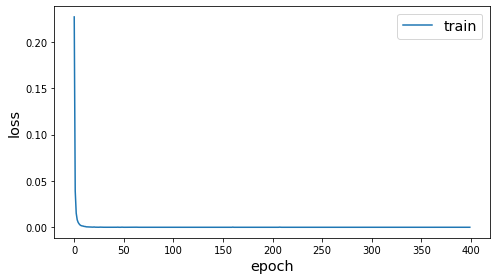

In [11]:
plot_history(history)

## Extracting Embeddings

Since we've already trained the weights of our base model - HinSAGE in this example - we can simply use `base_model.in_out_tensors` to obtain the trained node embedding model. 

In [12]:
x_emb_in, x_emb_out = graphsage_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
# x_out = tf.squeeze(x_emb_out, axis=0)
# emb_model = Model(inputs=x_emb_in, outputs=x_out)

# not using full batch models
emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

## Visualisation with TSNE

Here we visualize the node embeddings with TSNE. As you can see below, the Deep Graph Infomax model produces well separated embeddings using unsupervised training.

In [13]:
all_embeddings = emb_model.predict(graphsage_generator.flow(G.nodes()))

trans = TSNE(n_components=2, random_state=0)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=G.nodes())


In [14]:
def geneType(name):
    if name[-4:] == '_gm2':
        return 1
    elif name[-4:] == '_gm1':
        return 2
    else:
        return 0

emb_transformed['type'] = emb_transformed.index.map(geneType)

In [15]:
emb = pd.DataFrame(all_embeddings, index=G.nodes())
emb['type'] = emb.index.map(geneType)
emb[emb.index == 'ATF3_gm']
emb.to_csv(f'./emb/{MODEL_NAME}.csv', index=True, header=True)

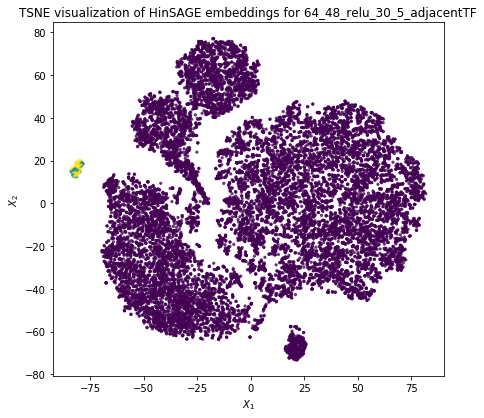

In [16]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"],
#     cmap="Paired",
    alpha=alpha,
    s=5
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(f"TSNE visualization of HinSAGE embeddings for {MODEL_NAME}")

plt.savefig(f'./img/full/{MODEL_NAME}.png', dpi=150)
plt.show()

